# IBM Data Science Capstone project Final Notebook

## The Business Problem: Opening Filipino Restaurant in Toronto

This notebook is to scrape the data from wikipedia load the geographical data and then cluster the data according to the business problem that needs answering, which is opening a new Filipino restaurant

In [100]:
# import the required packages
import requests
import pandas as pd
import numpy as np
import folium
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# scrape the neighbourhood data from wikipedia page
data = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
if data.status_code == 200:
    print('Page download successful')
else:
    print('Page download error. Error code: {}'.format(page.status_code))

Page download successful


In [3]:
#Load the neighbourhood data into pandas
df_html=pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M',header=0,na_values = ['Not assigned'])[0]
df_html.head()

,Postal Code,Borough,Neighbourhood
0,M1A,NaN,NaN
1,M2A,NaN,NaN
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [4]:
#Drop the the rows on which the Borough is empty
df_html.dropna(subset=['Borough'], inplace=True)

In [5]:
#Check Neighborhood is empty but Borough exists
n_empty_neighborhood = df_html[df_html['Neighbourhood'].isna()].shape[0]
print('Number of rows where Neighborhood column is empty: {}'.format(n_empty_neighborhood))

Number of rows where Neighborhood column is empty: 0


In [6]:
df_html.head()

,Postal Code,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [7]:
#Group by Postcode / Borough
df_postcodes = df_html.groupby(['Postal Code','Borough']).Neighbourhood.agg([('Neighbourhood', ', '.join)])
df_postcodes.reset_index(inplace=True)
df_postcodes.head(5)

,Postal Code,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [8]:
#Drop the the rows on which the Borough is empty
df_html.dropna(subset=['Borough'], inplace=True)

In [9]:
#Make a copy of the cleaned dataframe to merge with the geographical data
df_neighborhoods=df_html.copy()
df_neighborhoods.head()


,Postal Code,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [10]:
#Read CSV file from link and load into dataframe
url_csv = 'http://cocl.us/Geospatial_data'
df_coordinates = pd.read_csv(url_csv)
df_coordinates.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [11]:
# Make sure both dataframes have the same Index column to join the tables on
df_coordinates.rename({'Postal Code': 'PostalCode'},axis=1, inplace=True)
df_neighborhoods.rename({'Postal Code': 'PostalCode'},axis=1,inplace=True)

df_coordinates.info()
df_neighborhoods.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 3 columns):
PostalCode    103 non-null object
Latitude      103 non-null float64
Longitude     103 non-null float64
dtypes: float64(2), object(1)
memory usage: 2.5+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 103 entries, 2 to 178
Data columns (total 3 columns):
PostalCode       103 non-null object
Borough          103 non-null object
Neighbourhood    103 non-null object
dtypes: object(3)
memory usage: 3.2+ KB


In [12]:
# Merge both datasets
df_neighborhoods_coordinates = pd.merge(df_coordinates,df_neighborhoods, on='PostalCode')
df_neighborhoods_coordinates.head()

,PostalCode,Latitude,Longitude,Borough,Neighbourhood
0,M1B,43.806686,-79.194353,Scarborough,"Malvern, Rouge"
1,M1C,43.784535,-79.160497,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,43.763573,-79.188711,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,43.770992,-79.216917,Scarborough,Woburn
4,M1H,43.773136,-79.239476,Scarborough,Cedarbrae


In [13]:
# Check coordinates for a couple of neighborhoods
df_neighborhoods_coordinates[(df_neighborhoods_coordinates['PostalCode']=='M5G') |
                             (df_neighborhoods_coordinates['PostalCode']=='M2H') ]

,PostalCode,Latitude,Longitude,Borough,Neighbourhood
17,M2H,43.803762,-79.363452,North York,Hillcrest Village
57,M5G,43.657952,-79.387383,Downtown Toronto,Central Bay Street


In [17]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df_neighborhoods_coordinates['Borough'].unique()),
        df_neighborhoods_coordinates.shape[0]
    )
)

The dataframe has 10 boroughs and 103 neighborhoods.


In [19]:
df_neighborhoods_coordinates.rename({'Neighbourhood': 'Neighborhood'}, axis=1, inplace=True)

In [22]:
#count Borough and Neighborhood
df_neighborhoods_coordinates.groupby('Borough').count()['Neighborhood']

Borough
Central Toronto      9
Downtown Toronto    19
East Toronto         5
East York            5
Etobicoke           12
Mississauga          1
North York          24
Scarborough         17
West Toronto         6
York                 5
Name: Neighborhood, dtype: int64

In [23]:
df_toronto = df_neighborhoods_coordinates[df_neighborhoods_coordinates['Borough'].str.contains('Toronto')]
df_toronto.reset_index(inplace=True)
df_toronto.drop('index', axis=1, inplace=True)
df_toronto.head()

C:\Users\micha\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,PostalCode,Latitude,Longitude,Borough,Neighborhood
0,M4E,43.676357,-79.293031,East Toronto,The Beaches
1,M4K,43.679557,-79.352188,East Toronto,"The Danforth West, Riverdale"
2,M4L,43.668999,-79.315572,East Toronto,"India Bazaar, The Beaches West"
3,M4M,43.659526,-79.340923,East Toronto,Studio District
4,M4N,43.728020,-79.388790,Central Toronto,Lawrence Park


In [24]:
#Check the number of neighborhoods
print(df_toronto.groupby('Borough').count()['Neighborhood'])

Borough
Central Toronto      9
Downtown Toronto    19
East Toronto         5
West Toronto         6
Name: Neighborhood, dtype: int64


In [25]:
#Create list with the Boroughs (to be used later)
boroughs = df_toronto['Borough'].unique().tolist()

In [26]:
#Obtain the coordinates from the dataset itself, just averaging Latitude/Longitude of the current dataset 
lat_toronto = df_toronto['Latitude'].mean()
lon_toronto = df_toronto['Longitude'].mean()
print('The geographical coordinates of Toronto are {}, {}'.format(lat_toronto, lon_toronto))

The geographical coordinates of Toronto are 43.66713498717948, -79.38987324871795


In [27]:
borough_color = {}
for borough in boroughs:
    borough_color[borough]= '#%02X%02X%02X' % tuple(np.random.choice(range(256), size=3)) #Random color

In [101]:
map_toronto = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], 
                                           df_toronto['Longitude'],
                                           df_toronto['Borough'], 
                                           df_toronto['Neighborhood']):
    label_text = borough + ' - ' + neighborhood
    label = folium.Popup(label_text)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=borough_color[borough],
        fill_color=borough_color[borough],
        fill_opacity=0.7).add_to(map_toronto)  
    
map_toronto

# Retrieving the venue data using the foursquare API

In [29]:
CLIENT_ID = 'KOLQHCT2BHCU1MRD3MLAKO45BRAN24W2XYTJ4VET05NJRRZJ' # your Foursquare ID
CLIENT_SECRET = 'E52WORYNSYPTFEBG3DQRKKK33RXZWP4C1NLJJP03X0VM3VRC' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

In [30]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [31]:
#Get venues for all neighborhoods in our dataset
toronto_venues = getNearbyVenues(names=df_toronto['Neighborhood'],
                                latitudes=df_toronto['Latitude'],
                                longitudes=df_toronto['Longitude'])

The Beaches
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Lawrence Park
Davisville North
North Toronto West, Lawrence Park
Davisville
Moore Park, Summerhill East
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
Rosedale
St. James Town, Cabbagetown
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North & West, Forest Hill Road Park
The Annex, North Midtown, Yorkville
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Stn A PO Boxes
First Canadian Place, Underground city
Christie
Dufferin, Dovercourt Village
Little Portugal, Trinity
Brockton, Parkdale Village, Exhibition Place
High 

In [32]:
#Check size of resulting dataframe
toronto_venues.shape

(1644, 7)

In [71]:
#Number of venues per neighborhood
venues=toronto_venues.groupby('Neighborhood').count()
venues.head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,59,59,59,59,59,59
"Brockton, Parkdale Village, Exhibition Place",23,23,23,23,23,23
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",19,19,19,19,19,19
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",17,17,17,17,17,17
Central Bay Street,65,65,65,65,65,65


In [94]:
df_toptenvenues=venues.sort_values('Venue', ascending=False)

topten=df_toptenvenues[:14]

df_toptenvenues.head(10)

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Garden District, Ryerson",100,100,100,100,100,100
"Toronto Dominion Centre, Design Exchange",100,100,100,100,100,100
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
"Richmond, Adelaide, King",100,100,100,100,100,100
"Harbourfront East, Union Station, Toronto Islands",100,100,100,100,100,100
"First Canadian Place, Underground city",100,100,100,100,100,100
Stn A PO Boxes,98,98,98,98,98,98
St. James Town,85,85,85,85,85,85
Church and Wellesley,76,76,76,76,76,76


[Text(0, 0, 'Garden District, Ryerson'),
 Text(0, 0, 'Toronto Dominion Centre, Design Exchange'),
 Text(0, 0, 'Commerce Court, Victoria Hotel'),
 Text(0, 0, 'Richmond, Adelaide, King'),
 Text(0, 0, 'Harbourfront East, Union Station, Toronto Islands'),
 Text(0, 0, 'First Canadian Place, Underground city'),
 Text(0, 0, 'Stn A PO Boxes'),
 Text(0, 0, 'St. James Town'),
 Text(0, 0, 'Church and Wellesley'),
 Text(0, 0, 'Kensington Market, Chinatown, Grange Park'),
 Text(0, 0, 'Central Bay Street'),
 Text(0, 0, 'Berczy Park'),
 Text(0, 0, 'Little Portugal, Trinity'),
 Text(0, 0, 'St. James Town, Cabbagetown')]

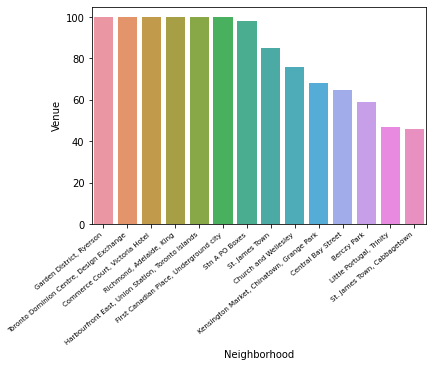

In [95]:
ax=sns.barplot(x=topten.index, y='Venue',data=topten)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right",fontsize=7)

In [34]:
#Number of unique venue categories
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 233 uniques categories.


In [35]:
#print out the list of categories
toronto_venues['Venue Category'].unique()[:100]

array(['Trail', 'Health Food Store', 'Pub', 'Neighborhood', 'Coffee Shop',
       'Cosmetics Shop', 'Greek Restaurant', 'Ice Cream Shop',
       'Italian Restaurant', 'Brewery', 'Juice Bar', 'Yoga Studio',
       'Restaurant', 'Fruit & Vegetable Store', 'Pizza Place',
       'Bookstore', 'Dessert Shop', 'Furniture / Home Store',
       'Bubble Tea Shop', 'Spa', 'Grocery Store', 'Café', 'Bakery',
       'Caribbean Restaurant', 'Indian Restaurant', 'Lounge',
       'American Restaurant', 'Frozen Yogurt Shop', 'Sushi Restaurant',
       'Liquor Store', 'Gym', 'Fast Food Restaurant', 'Fish & Chips Shop',
       'Park', 'Burrito Place', 'Pet Store', 'Steakhouse',
       'Movie Theater', 'Sandwich Place', 'Board Shop',
       'Food & Drink Shop', 'Fish Market', 'Gay Bar', 'Cheese Shop',
       'Seafood Restaurant', 'Middle Eastern Restaurant',
       'Stationery Store', 'Comfort Food Restaurant', 'Thai Restaurant',
       'Coworking Space', 'Wine Bar', 'Latin American Restaurant',
       'Ga

In [46]:
# check if the results contain "Thai Restaurants"
#please note I changed the data to Thai because I was previously writing the code using Asian but the number is so small
"Thai Restaurant" in toronto_venues['Venue Category'].unique()

True

In [47]:
# one hot encoding
to_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
to_onehot['Neighborhoods'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [to_onehot.columns[-1]] + list(to_onehot.columns[:-1])
to_onehot = to_onehot[fixed_columns]

print(to_onehot.shape)
to_onehot.head()

(1644, 234)


,Neighborhoods,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,The Beaches,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
to_grouped = to_onehot.groupby(["Neighborhoods"]).mean().reset_index()

print(to_grouped.shape)
to_grouped

(39, 234)


,Neighborhoods,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.00,0.016949,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.043478
2,"Business reply mail Processing Centre, South C...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.058824,0.058824,0.058824,0.117647,0.117647,0.117647,0.000000,0.000000,...,0.00000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Central Bay Street,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.00,0.015385,0.000000,0.000000,0.015385,0.000000,0.000000,0.015385
5,Christie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Church and Wellesley,0.013158,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013158,0.000000,...,0.00000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.026316
7,"Commerce Court, Victoria Hotel",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,...,0.00000,0.00000,0.00,0.020000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000
8,Davisville,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.03125,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Davisville North,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [49]:
len(to_grouped[to_grouped["Thai Restaurant"] > 0])

13

In [56]:
to_asian = to_grouped[["Neighborhoods","Thai Restaurant"]]
to_asian.head()

,Neighborhoods,Thai Restaurant
0,Berczy Park,0.016949
1,"Brockton, Parkdale Village, Exhibition Place",0.000000
2,"Business reply mail Processing Centre, South C...",0.000000
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000
4,Central Bay Street,0.030769


In [86]:
df_topten=to_asian.sort_values('Thai Restaurant', ascending=False)
df_topten.head(10)
topten=df_topten[:14]

[Text(0, 0, 'High Park, The Junction South'),
 Text(0, 0, 'Davisville'),
 Text(0, 0, 'Central Bay Street'),
 Text(0, 0, 'Richmond, Adelaide, King'),
 Text(0, 0, 'Studio District'),
 Text(0, 0, 'St. James Town, Cabbagetown'),
 Text(0, 0, 'First Canadian Place, Underground city'),
 Text(0, 0, 'Commerce Court, Victoria Hotel'),
 Text(0, 0, 'Berczy Park'),
 Text(0, 0, 'Church and Wellesley'),
 Text(0, 0, 'St. James Town'),
 Text(0, 0, 'Stn A PO Boxes'),
 Text(0, 0, 'Garden District, Ryerson'),
 Text(0, 0, 'The Annex, North Midtown, Yorkville')]

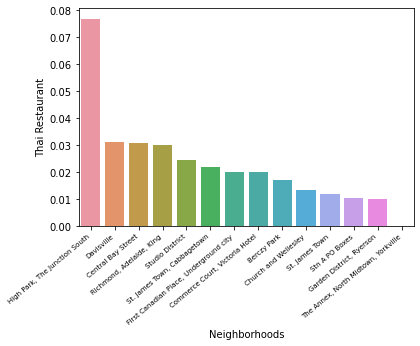

In [87]:
ax=sns.barplot(x='Neighborhoods', y='Thai Restaurant',data=topten)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right",fontsize=7)

In [57]:
# set number of clusters
toclusters = 3

to_clustering = to_asian.drop(["Neighborhoods"], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=toclusters, random_state=0).fit(to_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 1, 1, 1, 0, 1, 0, 0, 0, 1])

In [98]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(to_clustering)
    Sum_of_squared_distances.append(km.inertia_)

C:\Users\micha\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (13) found smaller than n_clusters (14). Possibly due to duplicate points in X.
  return_n_iter=True)


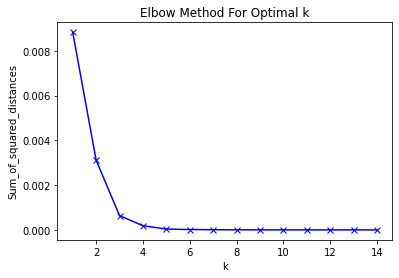

In [102]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [58]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
to_merged = to_asian.copy()

# add clustering labels
to_merged["Cluster Labels"] = kmeans.labels_

In [59]:
to_merged.rename(columns={"Neighborhoods": "Neighborhood"}, inplace=True)
to_merged.head()

,Neighborhood,Thai Restaurant,Cluster Labels
0,Berczy Park,0.016949,0
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,1
2,"Business reply mail Processing Centre, South C...",0.000000,1
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,1
4,Central Bay Street,0.030769,0


In [60]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
to_merged = to_merged.join(toronto_venues.set_index("Neighborhood"), on="Neighborhood")

print(to_merged.shape)
to_merged.head()

(1644, 9)


,Neighborhood,Thai Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Berczy Park,0.016949,0,43.644771,-79.373306,LCBO,43.642944,-79.372440,Liquor Store
0,Berczy Park,0.016949,0,43.644771,-79.373306,The Keg Steakhouse + Bar - Esplanade,43.646712,-79.374768,Restaurant
0,Berczy Park,0.016949,0,43.644771,-79.373306,Fresh On Front,43.647815,-79.374453,Vegetarian / Vegan Restaurant
0,Berczy Park,0.016949,0,43.644771,-79.373306,Meridian Hall,43.646292,-79.376022,Concert Hall
0,Berczy Park,0.016949,0,43.644771,-79.373306,Goose Island Brewhouse,43.647329,-79.373541,Beer Bar


In [61]:
# sort the results by Cluster Labels
print(to_merged.shape)
to_merged.sort_values(["Cluster Labels"], inplace=True)
to_merged

(1644, 9)


,Neighborhood,Thai Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Berczy Park,0.016949,0,43.644771,-79.373306,LCBO,43.642944,-79.372440,Liquor Store
32,Studio District,0.024390,0,43.659526,-79.340923,7-Eleven,43.660897,-79.340159,Convenience Store
32,Studio District,0.024390,0,43.659526,-79.340923,The Roy Public House,43.660452,-79.342994,Bar
32,Studio District,0.024390,0,43.659526,-79.340923,Dwell Gym,43.663412,-79.341104,Gym / Fitness Center
32,Studio District,0.024390,0,43.659526,-79.340923,The Thirsty Duck,43.661138,-79.340110,Gastropub
...,...,...,...,...,...,...,...,...,...
15,"High Park, The Junction South",0.076923,2,43.661608,-79.464763,The Beet Organic Café,43.665340,-79.467137,Café
15,"High Park, The Junction South",0.076923,2,43.661608,-79.464763,Junction City Music Hall,43.665334,-79.466253,Music Venue
15,"High Park, The Junction South",0.076923,2,43.661608,-79.464763,Playa Cabana Cantina,43.665315,-79.465548,Mexican Restaurant
15,"High Park, The Junction South",0.076923,2,43.661608,-79.464763,ROUX,43.665418,-79.462392,Cajun / Creole Restaurant


In [96]:
# create map
map_clusters = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=11)

# set color scheme for the clusters
x = np.arange(toclusters)
ys = [i+x+(i*x)**2 for i in range(toclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(to_merged['Neighborhood Latitude'], to_merged['Neighborhood Longitude'], to_merged['Neighborhood'], to_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [64]:
# save the map as HTML file
map_clusters.save('map_clusters.html')

# Examine Clusters

In [65]:
#Cluster 0
cluster0=to_merged.loc[to_merged['Cluster Labels'] == 0]

,Neighborhood,Thai Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Berczy Park,0.016949,0,43.644771,-79.373306,LCBO,43.642944,-79.372440,Liquor Store
32,Studio District,0.024390,0,43.659526,-79.340923,7-Eleven,43.660897,-79.340159,Convenience Store
32,Studio District,0.024390,0,43.659526,-79.340923,The Roy Public House,43.660452,-79.342994,Bar
32,Studio District,0.024390,0,43.659526,-79.340923,Dwell Gym,43.663412,-79.341104,Gym / Fitness Center
32,Studio District,0.024390,0,43.659526,-79.340923,The Thirsty Duck,43.661138,-79.340110,Gastropub
...,...,...,...,...,...,...,...,...,...
7,"Commerce Court, Victoria Hotel",0.020000,0,43.648198,-79.379817,Canoe,43.647452,-79.381320,Restaurant
7,"Commerce Court, Victoria Hotel",0.020000,0,43.648198,-79.379817,Portico,43.651856,-79.378055,Restaurant
7,"Commerce Court, Victoria Hotel",0.020000,0,43.648198,-79.379817,Mercatto,43.650243,-79.380820,Italian Restaurant
7,"Commerce Court, Victoria Hotel",0.020000,0,43.648198,-79.379817,Over Easy,43.648077,-79.377599,Breakfast Spot


# Examine the Clusters

In [66]:
#Cluster 1
cluster1=to_merged.loc[to_merged['Cluster Labels'] == 1]

,Neighborhood,Thai Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
37,"Toronto Dominion Centre, Design Exchange",0.0,1,43.647177,-79.381576,Brooks Brothers,43.646852,-79.379447,Clothing Store
37,"Toronto Dominion Centre, Design Exchange",0.0,1,43.647177,-79.381576,Irish Embassy,43.647918,-79.377273,Irish Pub
37,"Toronto Dominion Centre, Design Exchange",0.0,1,43.647177,-79.381576,Mercatto,43.650243,-79.380820,Italian Restaurant
37,"Toronto Dominion Centre, Design Exchange",0.0,1,43.647177,-79.381576,Szechuan Express,43.646973,-79.379549,Chinese Restaurant
37,"Toronto Dominion Centre, Design Exchange",0.0,1,43.647177,-79.381576,Ruth's Chris Steak House,43.649917,-79.385724,Steakhouse
...,...,...,...,...,...,...,...,...,...
17,"Kensington Market, Chinatown, Grange Park",0.0,1,43.653206,-79.400049,A & C World,43.657409,-79.399847,Gaming Cafe
17,"Kensington Market, Chinatown, Grange Park",0.0,1,43.653206,-79.400049,Urban Herbivore,43.656193,-79.402673,Vegetarian / Vegan Restaurant
17,"Kensington Market, Chinatown, Grange Park",0.0,1,43.653206,-79.400049,Gushi,43.652258,-79.404884,Japanese Restaurant
17,"Kensington Market, Chinatown, Grange Park",0.0,1,43.653206,-79.400049,Big Trouble Pizza,43.651347,-79.397020,Pizza Place


In [67]:
#Cluster 2
cluster2=to_merged.loc[to_merged['Cluster Labels'] == 2]

,Neighborhood,Thai Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
15,"High Park, The Junction South",0.076923,2,43.661608,-79.464763,ARTiculations,43.665550,-79.467194,Arts & Crafts Store
15,"High Park, The Junction South",0.076923,2,43.661608,-79.464763,Lithuania Park,43.658667,-79.463038,Park
15,"High Park, The Junction South",0.076923,2,43.661608,-79.464763,nodo,43.665303,-79.465621,Italian Restaurant
15,"High Park, The Junction South",0.076923,2,43.661608,-79.464763,Hole in the Wall,43.665296,-79.465118,Bar
15,"High Park, The Junction South",0.076923,2,43.661608,-79.464763,Indie Alehouse,43.665475,-79.465290,Gastropub
15,"High Park, The Junction South",0.076923,2,43.661608,-79.464763,Junction Flea,43.665258,-79.462868,Flea Market
15,"High Park, The Junction South",0.076923,2,43.661608,-79.464763,famous last words,43.665181,-79.468471,Speakeasy
15,"High Park, The Junction South",0.076923,2,43.661608,-79.464763,Mjölk,43.665432,-79.467962,Furniture / Home Store
15,"High Park, The Junction South",0.076923,2,43.661608,-79.464763,Grand Bargain,43.665423,-79.467600,Convenience Store
15,"High Park, The Junction South",0.076923,2,43.661608,-79.464763,See-Scape,43.665400,-79.463995,Restaurant


# Observations

Most of Thai restaurants are in Cluster 2 which is around Adelaide, King, Richmond areas and lowest (close to zero) in Cluster 1 areas which are North Toronto West and Parkdale areas. Also, there are good opportunities to open near Chinatown, St James town as the competition seems to be low. Looking at nearby venues, it seems Cluster 1 might be a good location as there are not a lot of Asian restaurants in these areas. Therefore, this project recommends the entrepreneur to open an authentic Filipino restaurant in these locations with little to no competition. Nonetheless, if the food is authentic, affordable and good taste, I am confident that it will have great following everywhere
